In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import collections
from powerlaw import Fit
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import community
from networkx.drawing.layout import bipartite_layout


In [25]:
df = pd.read_csv("data/RAW_recipes.csv")

In [26]:
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [27]:
# Extract relevant columns
df = df[['id', 'ingredients']].dropna()  # Keep only recipe ID and ingredient list

In [28]:
df.head()

,id,ingredients
0,137739,"['winter squash', 'mexican seasoning', 'mixed ..."
1,31490,"['prepared pizza crust', 'sausage patty', 'egg..."
2,112140,"['ground beef', 'yellow onions', 'diced tomato..."
3,59389,"['spreadable cheese with garlic and herbs', 'n..."
4,44061,"['tomato juice', 'apple cider vinegar', 'sugar..."


In [29]:
# Convert ingredients column from string to list (if stored as a string)
df['ingredients'] = df['ingredients'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [30]:
df.shape

(231637, 2)

In [31]:
df.head()

,id,ingredients
0,137739,"[winter squash, mexican seasoning, mixed spice..."
1,31490,"[prepared pizza crust, sausage patty, eggs, mi..."
2,112140,"[ground beef, yellow onions, diced tomatoes, t..."
3,59389,"[spreadable cheese with garlic and herbs, new ..."
4,44061,"[tomato juice, apple cider vinegar, sugar, sal..."


In [32]:
# Standardizing ingredient names
df['ingredients'] = df['ingredients'].apply(lambda x: [ing.lower().strip() for ing in x])

In [33]:
# Creating the bipartite graph
B = nx.Graph()

In [34]:
# Adding nodes (Recipes and Ingredients)
recipe_nodes = df['id'].tolist()  # Recipe nodes
ingredient_nodes = set(ing for recipe in df['ingredients'] for ing in recipe)  # Unique Ingredients

In [35]:
print(f'recipe nodes: {len(recipe_nodes)}')
print(f'ingredient nodes: {len(ingredient_nodes)}')


recipe nodes: 231637
ingredient nodes: 14942


In [36]:
B.add_nodes_from(recipe_nodes, bipartite=0)  # Recipe side
B.add_nodes_from(ingredient_nodes, bipartite=1)  # Ingredient side


In [37]:
# Adding edges (Recipe-Ingredient connections)
edges = [(recipe, ingredient) for recipe, ingredients in zip(df['id'], df['ingredients']) for ingredient in ingredients]
B.add_edges_from(edges)

In [38]:
# Compute basic statistics
num_nodes = B.number_of_nodes()
num_edges = B.number_of_edges()
print(f"Number of Nodes (N): {num_nodes}")
print(f"Number of Edges (E): {num_edges}")

Number of Nodes (N): 246579
Number of Edges (E): 2096582


In [39]:
recipe_degrees = [B.degree(recipe) for recipe in recipe_nodes]
ingredient_degrees = [B.degree(ingredient) for ingredient in ingredient_nodes]

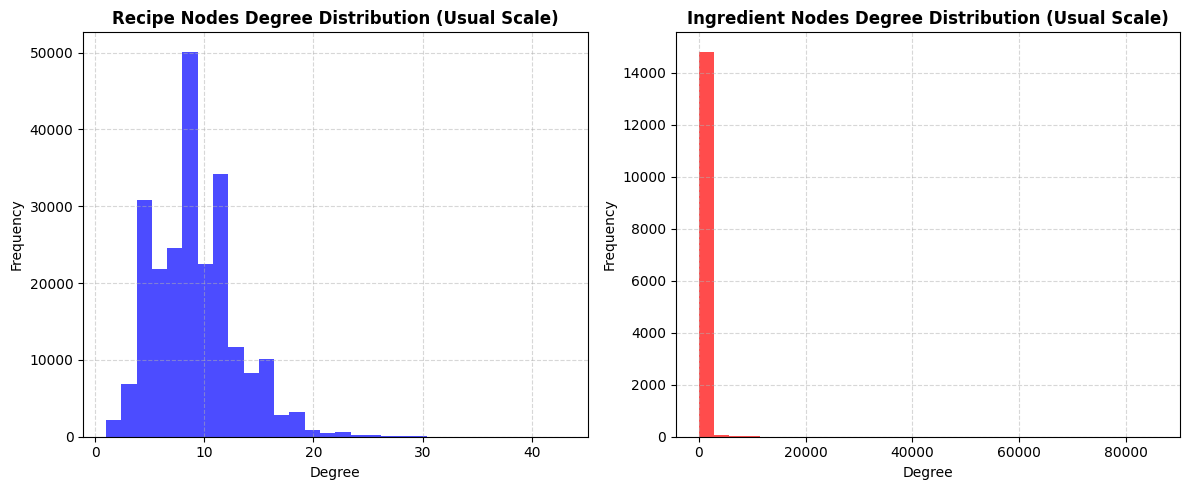

In [40]:
# --------- Figure 1: Usual Scale Degree Distribution ----------
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))

# Recipe Nodes - Usual Scale
axes1[0].hist(recipe_degrees, bins=30, alpha=0.7, color='blue')
axes1[0].set_xlabel("Degree")
axes1[0].set_ylabel("Frequency")
axes1[0].set_title("Recipe Nodes Degree Distribution (Usual Scale)", fontsize=12, fontweight='bold')
axes1[0].grid(True, linestyle="--", alpha=0.5)

# Ingredient Nodes - Usual Scale
axes1[1].hist(ingredient_degrees, bins=30, alpha=0.7, color='red')
axes1[1].set_xlabel("Degree")
axes1[1].set_ylabel("Frequency")
axes1[1].set_title("Ingredient Nodes Degree Distribution (Usual Scale)", fontsize=12, fontweight='bold')
axes1[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("degree_distribution_usual.png", dpi=300, bbox_inches='tight')
plt.show()

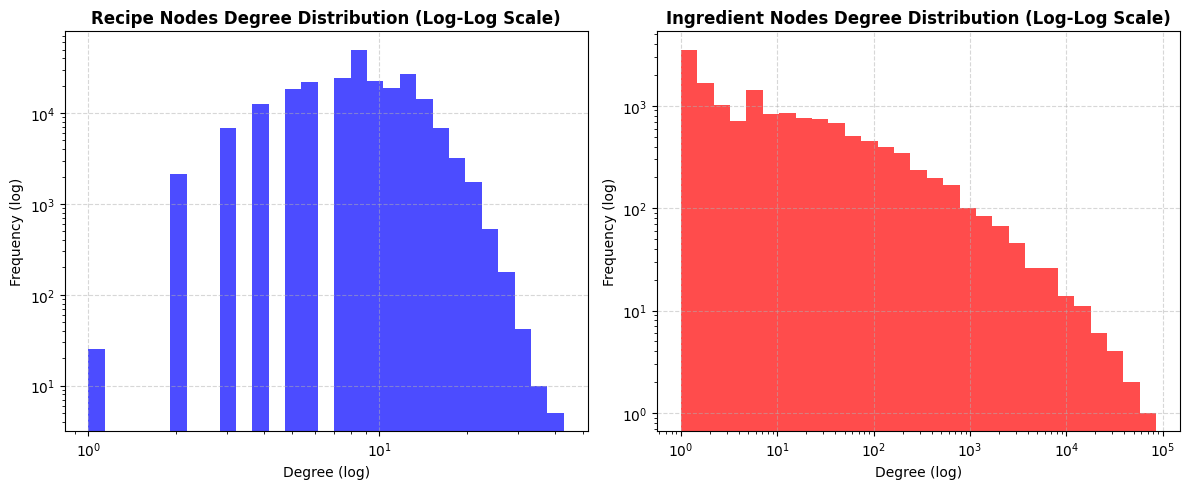

In [41]:
# --------- Figure 2: Log-Log Scale Degree Distribution ----------
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

# Recipe Nodes - Log-Log Scale
axes2[0].hist(recipe_degrees, bins=np.logspace(np.log10(1), np.log10(max(recipe_degrees)), 30), alpha=0.7, color='blue')
axes2[0].set_xscale("log")
axes2[0].set_yscale("log")
axes2[0].set_xlabel("Degree (log)")
axes2[0].set_ylabel("Frequency (log)")
axes2[0].set_title("Recipe Nodes Degree Distribution (Log-Log Scale)", fontsize=12, fontweight='bold')
axes2[0].grid(True, linestyle="--", alpha=0.5)

# Ingredient Nodes - Log-Log Scale
axes2[1].hist(ingredient_degrees, bins=np.logspace(np.log10(1), np.log10(max(ingredient_degrees)), 30), alpha=0.7, color='red')
axes2[1].set_xscale("log")
axes2[1].set_yscale("log")
axes2[1].set_xlabel("Degree (log)")
axes2[1].set_ylabel("Frequency (log)")
axes2[1].set_title("Ingredient Nodes Degree Distribution (Log-Log Scale)", fontsize=12, fontweight='bold')
axes2[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("degree_distribution_loglog.png", dpi=300, bbox_inches='tight')
plt.show()

In [1]:
def detect_bipartite_communities(B):
    """
    Detects communities in a bipartite graph using projection.

    Parameters:
    - B (networkx.Graph): The bipartite graph.

    Returns:
    - modularity (float): The modularity score.
    - partition (dict): Community assignments of nodes.
    - projected_G (networkx.Graph): The projected graph used for detection.
    """
    # Step 1: Identify left and right nodes
    left_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 0}
    right_nodes = set(B) - left_nodes  # Right-side nodes
    
    # Step 2: Create a projection (choose one side, e.g., left)
    projected_G = nx.bipartite.weighted_projected_graph(B, left_nodes)

    # Step 3: Apply community detection (Louvain)
    partition = community.best_partition(projected_G)

    # Step 4: Compute modularity
    modularity = community.modularity(partition, projected_G)
    
    return modularity, partition, projected_G


In [43]:
modularity, partition, projected_G = detect_bipartite_communities(B)

: 

In [ ]:
print("Modularity Score:", modularity)
print("Number of Communities:", len(set(partition.values())))